## Image Segmentation

see eg paper: Brain Tumor detection using color-based K-means clustering segmentation

challenge in neuroscience: tracking tumor objects in mr brain images

idea: gray scale image of the brain, translate into colored image (RGB) s.t. each pixel has three coordinates, cluster those data points in the hope that each different brain material is assigned the same cluster (e.g. bone, soft tissue, fat, background and the tumor). 

why consensus clustering/ parameter search? there is a need for fast and accurate clustering, with the help of consensus clustering we can find the parameters for a fast clustering technique and then use on many brain images. also one could do just consensus clustering (computationally expensive) in the hope for a better result.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from consensus_clustering import consensus
from consensus_clustering.lib import distance as cl_dist
from consensus_clustering.lib import density
from consensus_clustering.lib import similarity
from consensus_clustering.load_data import scale_data
import pandas as pd
import sys
from pandas.plotting import scatter_matrix
import seaborn.apionly as sns
#sns.set(style="ticks", color_codes=True)
%matplotlib inline

### Load data (txt file format)

data source: https://figshare.com/articles/brain_tumor_dataset/1512427

In [5]:
image=open(".\\consensus_clustering\\data\\brain.txt",'r')
brain=image.read()
image.close()

Convert to array of shape 512x512

In [32]:
brainarr=np.zeros((262144,))
index=0
for i in brain.split('\n'):
    for j in i.split(','):
        if j=='':
            continue
        integerv=int(j)
        brainarr[index]=integerv
        index+=1

In [33]:
brainarr2=np.reshape(brainarr,(512,512))

Plot the grayscale image, note: python automatically assigns a pseudocolor to each pixel for plotting

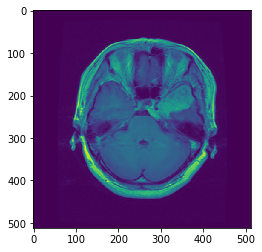

In [34]:
plt.imshow(brainarr2)

### Turn grayscale image into RGB image using the Python colormap

In [35]:
brainarr_rgb=np.zeros((512,512,4))

In [36]:
import matplotlib.cm as cm
index_j=0
index_k=0
for j in np.arange(512):
    for k in np.arange(512):
        brainarr_rgb[j,k,:]=cm.spectral((brainarr2[j,k]-np.min(brainarr))/3366)

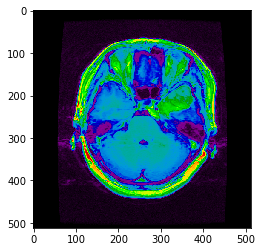

In [37]:
plt.imshow(brainarr_rgb)

Visualize data and preprocess for clustering

In [38]:
data_large=brainarr_rgb.reshape((262144,4))

Cut image in order to decrease amount of data points for clustering

In [76]:
brainarr_rgb_small=brainarr_rgb[np.arange(50,300),:,:]
brainarr_rgb_small=brainarr_rgb_small[:,np.arange(100,440),:]
#plt.imshow(brainarr_rgb_small)

#brainarr_grey_small=brainarr2[np.arange(50,300),:]
#brainarr_grey_small=brainarr_grey_small[:,np.arange(100,440)]

data_small=brainarr_rgb_small.reshape((85000,4))
#data_small_grey=brainarr_grey_small.reshape((85000,1))

Decrease pixel size

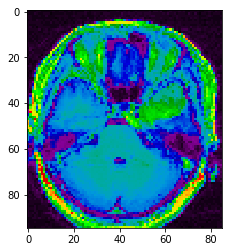

In [40]:
#np.shape(brainarr_grey_small)

#brainarr_grey_decr=brainarr_grey_small[np.arange(0,250,4),:]
#brainarr_grey_decr=brainarr_grey_decr[:,np.arange(0,340,4)]

#data_grey_decr=np.reshape(brainarr_grey_decr,(5355,1))

#plt.imshow(brainarr_grey_decr)


brainarr_rgb_decr_cut=brainarr_rgb_small[np.arange(0,250,4),:,:]
brainarr_rgb_decr_cut=brainarr_rgb_decr_cut[:,np.arange(0,340,4),:]
data_rgb_decr_cut=np.reshape(brainarr_rgb_decr_cut,(5355,4))

#plt.imshow(brainarr_rgb_decr)

#not cut
brainarr_rgb_decr=brainarr_rgb[np.arange(50,430,4),:,:]
brainarr_rgb_decr=brainarr_rgb_decr[:,np.arange(100,440,4),:]
data_rgb_decr=np.reshape(brainarr_rgb_decr,(np.shape(brainarr_rgb_decr)[0]*np.shape(brainarr_rgb_decr)[1],4))

plt.imshow(brainarr_rgb_decr)

### DBSCAN

Remark: This data set is probably not good for density based methods!

In [56]:
data_scaled=scale_data(data_rgb_decr[:,0:3])

dbscan_obj = density.DBSCAN(data_scaled,eps=0.2, minPts=17)
dbscan_obj.fit()
labels = np.array(dbscan_obj._cluster_labels)

Detected 26 clusters
Finished after 0:00:03.908708
Rate of noise in dataset: 0.017090


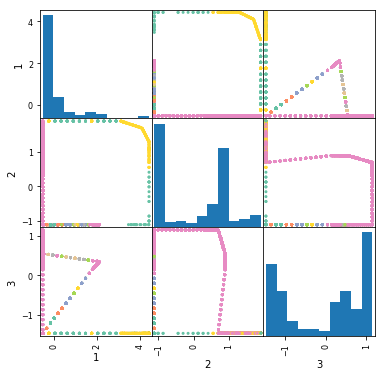

In [57]:
dataframeds=pd.DataFrame(data,columns=["1","2","3"])
dataframeds["labels"]=labels

#plot clustering result
s=scatter_matrix(dataframeds[["1","2","3"]], alpha=1, figsize=(6,6), c = labels, cmap='Set2')

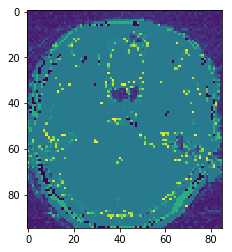

In [58]:
plt.imshow(labels.reshape(np.shape(brainarr_rgb_decr[:,:,0])))

### K-Means

Remark: Works quite well for this example, might be good to use K-Means for parameter search with consensus clustering

In [61]:
k = 3
data_scaled=scale_data(data_rgb_decr[:,0:3])

# Fit
kmeans_object = cl_dist.KMeans(data_scaled, k)
kmeans_object.fit()
labels = kmeans_object.cluster_labels

# Plot
dataframekm=pd.DataFrame(data_rgb_decr,columns=["1","2","3","4"])
dataframekm["labels"]=labels

terminated by break condition
14 iterations until termination.
Finished after 0:00:00.029597
max within-cluster distance to center: 4.152576
mean within-cluster distance to center: 0.893601
sum of within cluster squared errors: 9656.651530


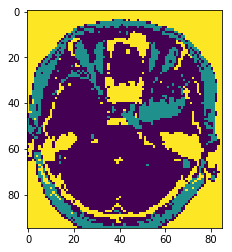

In [62]:
plt.imshow(labels.reshape(np.shape(brainarr_rgb_decr[:,:,0])))

### Parameter Search for Mean Shift

Remark: not feasable right now, too large of a data set, also the data doesn't seem to be good for density-based methods

In [63]:
def plot_results(data, cl_objects, nmi_arr, consensus_obj, algorithm, arr_x, arr_y):
    # Put labels in right order in to the labels array
    no_labels = [0] * len(data)
    clusterings_labels = []
    for obj in cl_objects:
        clusterings_labels.append(consensus_obj._noise_to_zero(obj).cluster_labels)
    print("Number of clusterings:", len(clusterings_labels))

    # Init plotting arrangement
    num_plots = len(cl_objects) + 2
    num_subplts_per_row = 6
    num_rows = np.ceil(num_plots / num_subplts_per_row).astype(int) + 1
    num_x_param = len(arr_x)
    num_y_param = len(arr_y)
    if num_y_param > 1:
        num_subplts_per_row = num_x_param
        num_rows = num_y_param + 1
    num_cols = min(num_subplts_per_row, num_plots)
    fig, axarr = plt.subplots(num_rows,num_cols, figsize=(17, 3*num_rows))

    # Plot labels
    for i, ax in enumerate(axarr.flat):
        cur_x = i % num_subplts_per_row
        cur_y = i // num_subplts_per_row - 1 # do not count first row with original data and consensus
        ax.axis('off')
        if i==0:
            ax.set_title('Original data')
            ax.set_aspect('equal')
            ax.scatter(data[:, 0], data[:, 1], s=40, c=no_labels, cmap='Set2', alpha=0.2)
        elif i==1:
            ax.set_title('Consensus')
            ax.set_aspect('equal')
            ax.scatter(data[:, 0], data[:, 1], s=40, c=consensus_obj.cluster_labels, cmap='Set2', alpha=0.2)
        elif any((i < num_subplts_per_row, i-num_subplts_per_row >= len(clusterings_labels))):
            continue
        else:   
            ax.set_aspect('equal')
            ax.scatter(data[:, 0], data[:, 1], s=40, c=clusterings_labels[i-num_subplts_per_row], cmap='Set2', alpha=0.2)
            if algorithm == 'kmeans':
                ax.set_title('k = {:}, \nNMI = {:.3}'.format(arr_x[cur_x], nmi_arr[i-num_subplts_per_row]))
            elif algorithm == 'dbscan':
#                 print(cur_x)
#                 print(cur_y)
                ax.set_title('eps = {:.3}, minPts = {:}\nNMI = {:.3}'.format(arr_x[cur_x], arr_y[cur_y], nmi_arr[i-num_subplts_per_row]))
            elif algorithm == 'meanshift':
                ax.set_title('bw = {:.3}, mindist = {:}\nNMI = {:.3}'.format(arr_x[cur_x], arr_y[cur_y], nmi_arr[i-num_subplts_per_row]))
           
            else:
                print("ERROR: Could not recognize algorithm parameter!")
                break

    plt.tight_layout()
    plt.show()
    #fig.savefig("bandwidth estimation.png")

In [70]:
def param_search_meanshift(data, k_consensus, recluster_what, recluster_how, bandwidth_arr,mindist_arr):
    num_objects = len(bandwidth_arr)
    ms_objects = [None] * num_objects
    ms_obj = None

    print("Fit Mean Shift objects")

    #Fit Mean Shift objects
    for i, (bandwidth, mindist) in enumerate(zip(bandwidth_arr, mindist_arr)):
        sys.stdout.write('\rbandwidth: {0}, mindist: {1}'.format(bandwidth, mindist))
        ms_obj = density.MeanShift(data, bandwidth=bandwidth, mindist=mindist, verbose=False)
        ms_obj.fit()
        ms_objects[i] = ms_obj

    print("\nFit consensus")

    # Fit consensus
    clusterings = [*ms_objects]
    consensus_obj = consensus.Consensus(clusterings=clusterings, k=k_consensus, recluster_what=recluster_what, how=recluster_how, verbose=True)
    consensus_labels = consensus_obj.cluster_labels

    print("Calculate NMI's")

    # Calculate NMI's
    nmi_array = np.zeros(num_objects)
    for i, (obj, nmi) in enumerate(zip(ms_objects, nmi_array)):
        nmi_array[i] = consensus_obj.nmi_with_me(consensus_obj._noise_to_zero(obj).cluster_labels)
    
    return nmi_array, ms_objects, consensus_obj

In [243]:
# Set parameters:

# General
stride = 1
data=scale_data(data_rgb_decr[:,0:3])
k_consensus = 3
recluster_what = 'points'
recluster_how = 'hierarchical'

# Mean Shift Parameter ranges
#first estimate bandwidth using scotts rule
n,d=np.shape(data)
bw_estimate=n**(-1./(d + 4))
print("The estimate bandwidth using scott's rule is", bw_estimate)

bw_arr = np.arange(0.1, 0.2, 0.05)#bandwidth
mindist_arr = np.linspace(0.02, 0.04, 3) #minimum distance
mesh_bw, mesh_mindist = np.meshgrid(bw_arr, mindist_arr)

The estimate bandwidth using scott's rule is 0.2765901955007549


In [203]:
#nmi_arr_ms, cl_objects_ms, consensus_obj_ms = param_search_meanshift(
    #data = data,
    #k_consensus = k_consensus,
    #recluster_what = recluster_what,
    #recluster_how = recluster_how,
    #bandwidth_arr = mesh_bw.flatten(),
    #mindist_arr = mesh_mindist.flatten())

In [17]:
#plot_results(data=data, cl_objects=cl_objects_ms, nmi_arr=nmi_arr_ms, consensus_obj=consensus_obj_ms, algorithm='meanshift', arr_x=bw_arr, arr_y=mindist_arr)

### Parameter search for DBSCAN

In [65]:
def param_search_dbscan(data, k_consensus, recluster_what, recluster_how, eps_arr, min_pts_arr):
    num_objects = len(eps_arr)
    dbscan_objects = [None] * num_objects
    dbscan_obj = None

    print("Fit DBSCAN objects")

    # Fit DBSCAN objects
    for i, (eps, minPts) in enumerate(zip(eps_arr, min_pts_arr)):
        sys.stdout.write('\reps: {0}, minPts: {1}'.format(eps, minPts))
        dbscan_obj = density.DBSCAN(data, eps=eps, minPts=minPts, verbose=False)
        dbscan_obj.fit()
        dbscan_objects[i] = dbscan_obj

    print("\nFit consensus")

    # Fit consensus
    clusterings = [*dbscan_objects]
    consensus_obj = consensus.Consensus(clusterings=clusterings, k=k_consensus, recluster_what=recluster_what, how=recluster_how, verbose=True)
    consensus_labels = consensus_obj.cluster_labels

    print("Calculate NMI's")

    # Calculate NMI's
    nmi_array = np.zeros(num_objects)
    for i, (obj, nmi) in enumerate(zip(dbscan_objects, nmi_array)):
        nmi_array[i] = consensus_obj.nmi_with_me(consensus_obj._noise_to_zero(obj).cluster_labels)
    
    return nmi_array, dbscan_objects, consensus_obj

In [66]:
# Set parameters:

# General
stride = 1
data = scale_data(data_rgb_decr[:,0:3])
k_consensus = 3
recluster_what = 'points'
recluster_how = 'hierarchical'

# DBSCAN
n_eps = 3
n_min_pts =10
eps_arr = np.linspace(0.2, 0.4, n_eps)
min_pts_min = 10
min_pts_arr = np.arange(min_pts_min, min_pts_min + n_min_pts,5)
mesh_eps, mesh_min_pts = np.meshgrid(eps_arr, min_pts_arr)

In [67]:
#nmi_arr_db, cl_objects_db, consensus_obj_db = param_search_dbscan(
   # data = data,
   # k_consensus = k_consensus,
   # recluster_what = recluster_what,
   # recluster_how = recluster_how,
   # eps_arr = mesh_eps.flatten(),
   # min_pts_arr = mesh_min_pts.flatten())

In [68]:
# plot_results(data=data, cl_objects=cl_objects_db, nmi_arr=nmi_arr_db, consensus_obj=consensus_obj_db, algorithm='dbscan', arr_x=eps_arr, arr_y=min_pts_arr)

In [69]:
# plt.imshow(consensus_obj_db.cluster_labels.reshape(np.shape(brainarr_grey_decr)[0:2]))

### Parameter search for KMeans Algorithm

In [71]:
def param_search_kmeans(data, k_consensus, recluster_what, recluster_how, k_arr):
    num_objects = len(k_arr)
    kmeans_objects = [None] * num_objects
    kmeans_obj = None

    print("Fit kmeans objects")

    # Fit kmeans objects
    for i, k in enumerate(k_arr):
        kmeans_obj = cl_dist.KMeans(data=data, k=k, verbose=False)
        kmeans_obj.fit()
        kmeans_objects[i] = kmeans_obj

    print("Fit consensus")

    # Fit consensus
    clusterings = [*kmeans_objects]
    consensus_obj = consensus.Consensus(clusterings=clusterings, k=k_consensus, recluster_what=recluster_what, how=recluster_how, verbose=True)
    consensus_labels = consensus_obj.cluster_labels

    print("Calculate NMI's")

    # Calculate NMI's
    nmi_array = np.zeros(num_objects)
    for i, (obj, nmi) in enumerate(zip(kmeans_objects, nmi_array)):
        nmi_array[i] = consensus_obj.nmi_with_me(consensus_obj._noise_to_zero(obj).cluster_labels)
    
    return nmi_array, kmeans_objects, consensus_obj

In [72]:
# Set parameters:

# General
data = scale_data(data_rgb_decr[:,0:3])
k_consensus = 3
recluster_what = 'points'
recluster_how = 'hierarchical'

#KMeans
km_arr = np.arange(2,6)

In [73]:
nmi_arr_km, cl_objects_km, consensus_obj_km = param_search_kmeans(
    data = data,
    k_consensus = k_consensus,
    recluster_what = recluster_what,
    recluster_how = recluster_how,
    k_arr = km_arr)

Fit kmeans objects
Fit consensus
Hierarchical clustering terminated.
Finished after 0:30:36.214397
Stopping cluster number was reached.
Current number of clusters: 3
Current minimum cluster distance: 0.75
mutual information: 5006.290833470003
entropy a: -7903.051462783722
entropy b: -5587.886307410404
mutual information: 7289.525104198798
entropy a: -7903.051462783722
entropy b: -8106.610552327162
mutual information: 7608.069234686276
entropy a: -7903.051462783722
entropy b: -9729.971575477288
mutual information: 7236.363133472638
entropy a: -7903.051462783722
entropy b: -12128.510846941788
Consensus clustering terminated.
Finished after 0:30:38.742066
ANMI (average normalized mutual information) of consensus with clusterings: 0.818
Calculate NMI's
mutual information: 5006.290833470003
entropy a: -7903.051462783722
entropy b: -5587.886307410404
mutual information: 7289.525104198798
entropy a: -7903.051462783722
entropy b: -8106.610552327162
mutual information: 7608.069234686276
entropy

Number of clusterings: 4


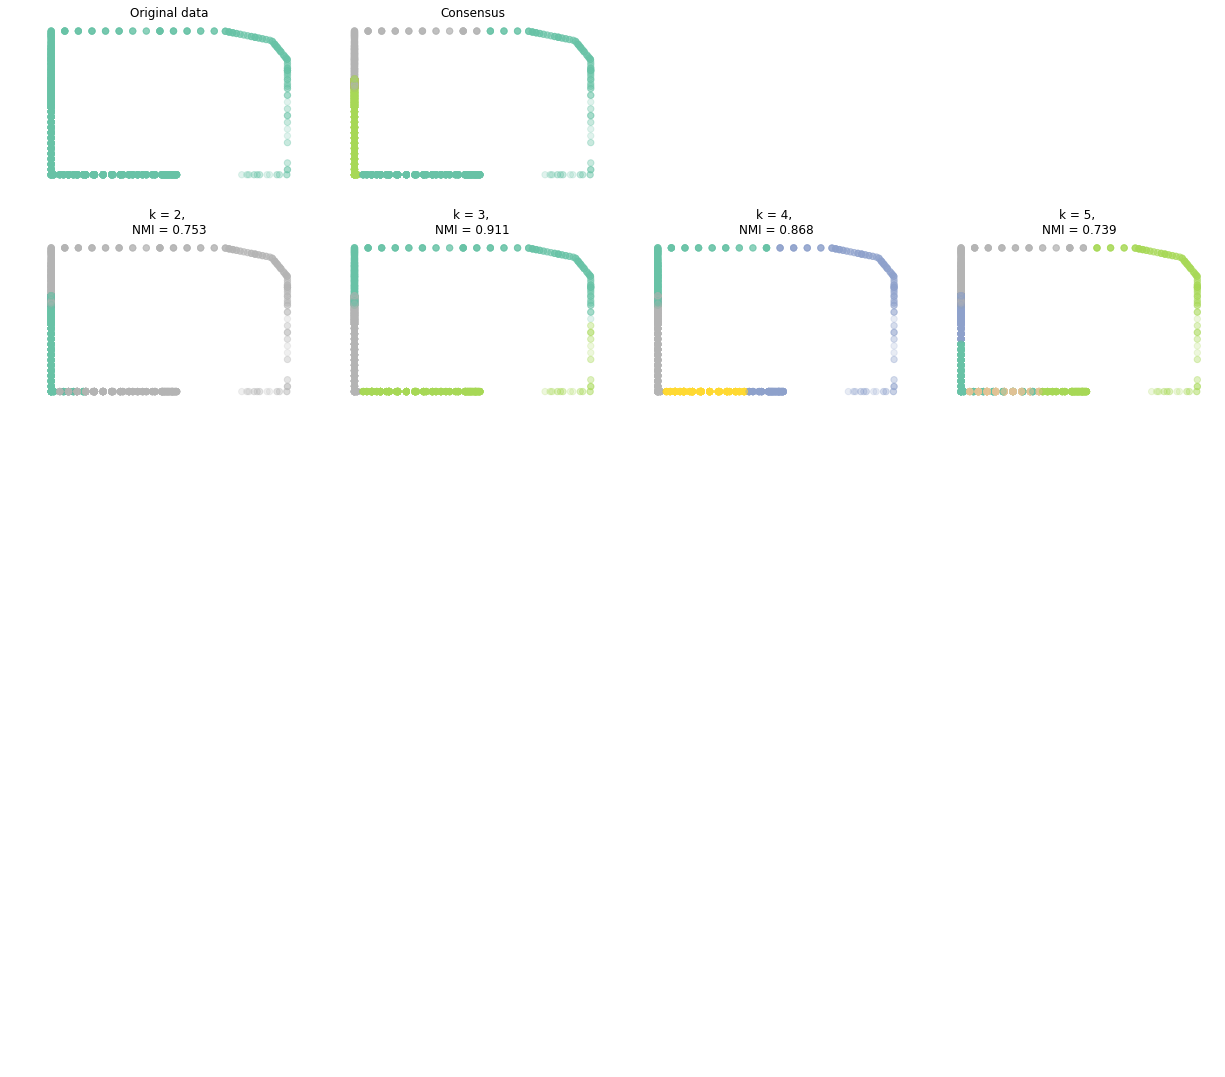

In [74]:
plot_results(data=data, cl_objects=cl_objects_km, nmi_arr=nmi_arr_km, consensus_obj=consensus_obj_km, algorithm='kmeans',  arr_x=km_arr, arr_y=np.zeros(len(km_arr)))

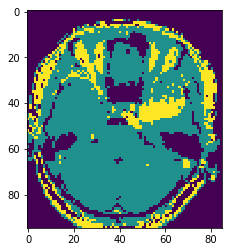

In [75]:
labels=consensus_obj_km.cluster_labels
plt.imshow(labels.reshape(np.shape(brainarr_rgb_decr)[0:2]))